In [5]:
%matplotlib inline
import os
import random
import numpy as np
import json
import matplotlib.pyplot
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE
import sys
import numpy as np
import json
import os
from os.path import isfile, join
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance

In [4]:
!pip install -U git+https://github.com/bmcfee/RasterFairy/ --user

  Cloning https://github.com/bmcfee/RasterFairy/ to /private/var/folders/9f/mbhf80g925v4y2rqkdftnwhr0000gp/T/pip-req-build-mpzo0j1t
  Running command git clone -q https://github.com/bmcfee/RasterFairy/ /private/var/folders/9f/mbhf80g925v4y2rqkdftnwhr0000gp/T/pip-req-build-mpzo0j1t
  Created wheel for rasterfairy: filename=rasterfairy-1.0.3-cp36-none-any.whl size=30377 sha256=36b45c2a4ab993be4a8fd00cdb11e48161211b2b3ba383eb94e9e8ad1eeb8d61
  Stored in directory: /private/var/folders/9f/mbhf80g925v4y2rqkdftnwhr0000gp/T/pip-ephem-wheel-cache-f0xvk_76/wheels/44/94/fe/551b99d4c1a07bacba1beddaafd0e6100d09ef4b1224869bc9
Successfully built rasterfairy
  Found existing installation: rasterfairy 1.0.3
    Uninstalling rasterfairy-1.0.3:
      Successfully uninstalled rasterfairy-1.0.3


In [7]:
basedir = "./data/"
images_path = os.path.join(basedir, "images")
jsondir = os.path.join(basedir,"json")

In [8]:
# Get the first frame from each of the gifs

In [9]:
for f in os.listdir("./gif"):
    imagepath = os.path.join("./gif", f)
    filename, file_extension = os.path.splitext(imagepath)
    image = Image.open(imagepath)
    image.seek(1)
    image = image.save(filename+".png",format="PNG")
    

FileNotFoundError: [Errno 2] No such file or directory: './gif'

In [2]:
# Make vectors from image

In [4]:
# variables for tsne
output_path = os.path.join(basedir,"json/out.json")
tsne_dimensions = 2
tsne_perplexity = 30
tsne_learning_rate = 150
num_comp = 30

In [5]:
def get_image(path, input_shape):
    img = image.load_img(path, target_size=input_shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def find_candidate_images(images_path):
    """
    Finds all candidate images in the given folder and its sub-folders.
    Returns:
        images: a list of absolute paths to the discovered images.
    """
    images = []
    for root, dirs, files in os.walk(images_path):
        for name in files:
            file_path = os.path.abspath(os.path.join(root, name))
            if ((os.path.splitext(name)[1]).lower() in ['.jpg','.png','.jpeg']):
                images.append(file_path)
    return images

def analyze_images(images_path):
    # make feature_extractor
    model = keras.applications.VGG16(weights='imagenet', include_top=True)
    feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
    input_shape = model.input_shape[1:3]
    # get images
    candidate_images = find_candidate_images(images_path)
    # analyze images and grab activations
    activations = []
    images = []
    for idx,image_path in enumerate(candidate_images):
        file_path = join(images_path,image_path)
        img = get_image(file_path, input_shape);
        if img is not None:
            print("getting activations for %s %d/%d" % (image_path,idx,len(candidate_images)))
            acts = feat_extractor.predict(img)[0]
            activations.append(acts)
            images.append(image_path)
    # run PCA firt
    print("Running PCA on %d images..." % len(activations))
    features = np.array(activations)
    pca = PCA(n_components=num_comp)
    pca.fit(features)
    pca_features = pca.transform(features)
    return images, pca_features

images, pca_features = analyze_images(images_path)
print("Running t-SNE on %d images..." % len(images))
X = np.array(pca_features)
tsne = TSNE(n_components=tsne_dimensions, learning_rate=tsne_learning_rate, perplexity=tsne_perplexity, verbose=2).fit_transform(X)
# save data to json
data = []
for i,f in enumerate(images):
    point = [float((tsne[i,k] - np.min(tsne[:,k]))/(np.max(tsne[:,k]) - np.min(tsne[:,k]))) for k in range(tsne_dimensions) ]
    data.append({"path":os.path.abspath(join(images_path,images[i])), "point":point})
with open(output_path, 'w') as outfile:
    json.dump(data, outfile)

Instructions for updating:
Colocations handled automatically by placer.
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/17_animation_733.png 0/33
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/26_animation_519.png 1/33
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/12_animation_444.png 2/33
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/8_animation_409.png 3/33
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/11_animation_72.png 4/33
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/0_animation_980.png 5/33
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/20_animation_394.png 6/33
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/1_animation_465.png 7/33
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/21_animation_282.png 8/33
getting activations for /Users/kkshmzmbp/gan-sketches/biggan/images/22_animation_768.p

In [7]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 3
ny = 11

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

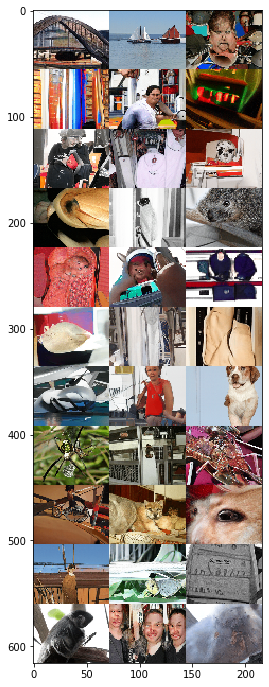

In [8]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)
